# Read Gamma + Muon Simulations and Fit to Lab Data + Smear (vz3)

#### Din-Ammar Tolj - Y25
Maruyama Group, Summer 2023

**OLD VERSION, USE VZ5 INSTEAD**

### Import needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import moyal, chisquare

import ROOT
from root_numpy import array2hist, hist2array, fill_hist

import sys
import math

import matplotlib as mpl
import os
import matplotlib.colors as colors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
# import deDisperse_util as util

mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
mpl.style.use('seaborn-colorblind')

from scipy.optimize import curve_fit
import scipy.signal
from lmfit.models import GaussianModel, ConstantModel
from datetime import datetime
from glob import glob

%cd /home/dt592/Geant4Work/gamma_sim/gamma_sim-build
from dt5202 import dt5202_crunch # Import parser that Tom wrote. This is containted in the file named dt5202.py in this folder.
from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ # Old ver
ped = 50 #pedestal correction

from langaus import LanGausFit # Import Langaus fit curve for PyROOT.
%cd -

import warnings
warnings.filterwarnings("ignore")

Welcome to JupyROOT 6.24/02


/tmp/ipykernel_10340/2577835370.py:25: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


/vast/palmer/home.grace/dt592/Geant4Work/gamma_sim/gamma_sim-build
/vast/palmer/home.grace/dt592/Geant4Work


### Import Simulated .ROOT Files

In [2]:
folder_g = "/home/dt592/Geant4Work/gamma_sim/gamma_sim-build/" # location of the gamma sim build folder
folder_m = "/home/dt592/Geant4Work/muons_edited/muonsInPanel_build/" # location of the muon sim build folder
 
# Open ROOT files
# f1460 = ROOT.TFile.Open(folder_g + "K40J_normalized.root","READ")
# f2614 = ROOT.TFile.Open(folder_g + "Tl208J_normalized.root","READ")
f1460 = ROOT.TFile.Open(folder_g + "K40-1460KeV-25x.root","READ")
f2614 = ROOT.TFile.Open(folder_g + "Tl208-2614KeV-25x.root","READ")

# Bismuth peaks
f1120 = ROOT.TFile.Open(folder_g + "Bi214-1120KeV-25x.root", "READ")
f1238 = ROOT.TFile.Open(folder_g + "Bi214-1238KeV-25x.root", "READ")
f1764 = ROOT.TFile.Open(folder_g + "Bi214-1764KeV-25x.root", "READ")
f2204 = ROOT.TFile.Open(folder_g + "Bi214-2204KeV-25x.root", "READ")

# Lower peaks
f968 = ROOT.TFile.Open(folder_g + "Ac228-968KeV-25x.root", "READ")
f934 = ROOT.TFile.Open(folder_g + "Bi214-934KeV-25x.root", "READ")
f911 = ROOT.TFile.Open(folder_g + "Ac228-911KeV-25x.root", "READ")
f609 = ROOT.TFile.Open(folder_g + "Bi214-609KeV-25x.root", "READ")
f583 = ROOT.TFile.Open(folder_g + "Tl208-583KeV-25x.root", "READ")

# Muons
muons = ROOT.TFile(folder_m + "muonsJ_normalized.root", "READ")

## 

# Read the TTree for main two gamma isotopes
tree1460 = f1460.Get("Hits")
tree2614 = f2614.Get("Hits")

# Read the TTree for the nearby Bismuth-214 isotopes
tree1120 = f1120.Get("Hits")
tree1238 = f1238.Get("Hits")
tree1764 = f1764.Get("Hits")
tree2204 = f2204.Get("Hits")

# Read the TTree for the remaining low-freq. isotopes
tree968 = f968.Get("Hits")
tree934 = f934.Get("Hits")
tree911 = f911.Get("Hits")
tree609 = f609.Get("Hits")
tree583 = f583.Get("Hits")

# For the TTree for Muons
a = muons.Get("ntuple")
muonstree = a.Get("parTup")

In [3]:
# Append the energy values from the TTree into an array
energyDeposited1460 = []
entries= tree1460.GetEntries();
for i in range(0,entries):
    tree1460.GetEntry(i)
    energyDeposited1460.append(tree1460.EnergyDeposited)

energyDeposited2614 = []
entries= tree2614.GetEntries();
for i in range(0,entries):
    tree2614.GetEntry(i)
    energyDeposited2614.append(tree2614.EnergyDeposited)
    
muonsEnergy = []
for event in muonstree:
    muonsEnergy.append(event.Edeposited)
    
## 
    
# Append the Bismuth peaks
energyDeposited1120 = []
entries= tree1120.GetEntries();
for i in range(0,entries):
    tree1120.GetEntry(i)
    energyDeposited1120.append(tree1120.EnergyDeposited)

energyDeposited1238 = []
entries= tree1238.GetEntries();
for i in range(0,entries):
    tree1238.GetEntry(i)
    energyDeposited1238.append(tree1238.EnergyDeposited)

energyDeposited1764 = []
entries= tree1764.GetEntries();
for i in range(0,entries):
    tree1764.GetEntry(i)
    energyDeposited1764.append(tree1764.EnergyDeposited)

energyDeposited2204 = []
entries= tree2204.GetEntries();
for i in range(0,entries):
    tree2204.GetEntry(i)
    energyDeposited2204.append(tree2204.EnergyDeposited)
    
# And the remaining peaks
energyDeposited968 = []
entries= tree968.GetEntries();
for i in range(0,entries):
    tree968.GetEntry(i)
    energyDeposited968.append(tree968.EnergyDeposited)

energyDeposited934 = []
entries= tree934.GetEntries();
for i in range(0,entries):
    tree934.GetEntry(i)
    energyDeposited934.append(tree934.EnergyDeposited)

energyDeposited911 = []
entries= tree911.GetEntries();
for i in range(0,entries):
    tree911.GetEntry(i)
    energyDeposited911.append(tree911.EnergyDeposited)

energyDeposited609 = []
entries= tree609.GetEntries();
for i in range(0,entries):
    tree609.GetEntry(i)
    energyDeposited609.append(tree609.EnergyDeposited)

energyDeposited583 = []
entries= tree583.GetEntries();
for i in range(0,entries):
    tree583.GetEntry(i)
    energyDeposited583.append(tree583.EnergyDeposited)

In [4]:
# Concatenate the energies into np arrays
g_mev = np.concatenate((energyDeposited1460,energyDeposited2614,energyDeposited1120,energyDeposited1238,energyDeposited1764,energyDeposited2204,energyDeposited968,energyDeposited934,energyDeposited911,energyDeposited609,energyDeposited583)) # gamma 
mu_mev = np.array(muonsEnergy) # muons
sim_mev = np.concatenate((g_mev, mu_mev)) # total

Warning in <TFile::Append>: Replacing existing TH1: tl208_1 (Potential memory leak).


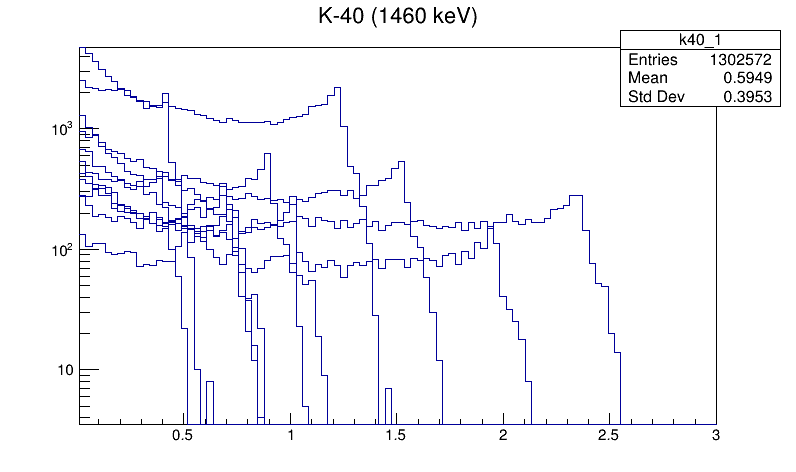

In [5]:
c1 = ROOT.TCanvas('c1','',800,500)

k40_1 = ROOT.TH1D('k40_1','K-40 (1460 keV)',100,0.01,3)
tl208_1 = ROOT.TH1D('tl208_1','a',100,0.01,3)
bi214_1 = ROOT.TH1D('bi214_1','b',100,0.01,3)
bi214_2 = ROOT.TH1D('bi214_2','c',100,0.01,3)
bi214_3 = ROOT.TH1D('bi214_3','d',100,0.01,3)
bi214_4 = ROOT.TH1D('bi214_4','e',100,0.01,3)
ac228_1 = ROOT.TH1D('ac228_1','f',100,0.01,3)
bi214_5 = ROOT.TH1D('bi214_5','g',100,0.01,3)
ac228_2 = ROOT.TH1D('ac228_2','h',100,0.01,3)
bi214_6 = ROOT.TH1D('bi214_6','i',100,0.01,3)
tl208_2 = ROOT.TH1D('tl208_1','j',100,0.01,3)

fill_hist(k40_1, np.array(energyDeposited1460))
fill_hist(tl208_1, np.array(energyDeposited2614))
fill_hist(bi214_1, np.array(energyDeposited1120))
fill_hist(bi214_2, np.array(energyDeposited1238))
fill_hist(bi214_3, np.array(energyDeposited1764))
fill_hist(bi214_4, np.array(energyDeposited2204))
fill_hist(ac228_1, np.array(energyDeposited968))
fill_hist(bi214_5, np.array(energyDeposited934))
fill_hist(ac228_2, np.array(energyDeposited911))
fill_hist(bi214_6, np.array(energyDeposited609))
fill_hist(tl208_2, np.array(energyDeposited583))

k40_1.Draw()
tl208_1.Draw("same")
bi214_1.Draw("same")
bi214_2.Draw("same")
bi214_3.Draw("same")
bi214_4.Draw("same")
ac228_1.Draw("same")
bi214_5.Draw("same")
ac228_2.Draw("same")
bi214_6.Draw("same")
tl208_2.Draw("same")

ROOT.gPad.SetLogy()

c1.Draw()

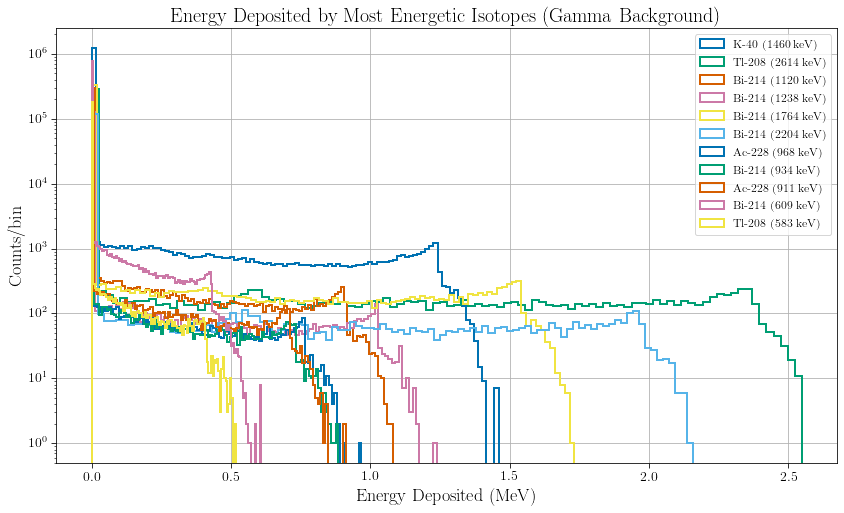

In [6]:
plt.figure(figsize=(14,8))

# Plot the gamma spectra
plt.hist(np.array(energyDeposited1460), bins=100, histtype="step", lw=2, label = "K-40 (1460 keV)")
plt.hist(np.array(energyDeposited2614), bins=100, histtype="step", lw=2, label = "Tl-208 (2614 keV)")
plt.hist(np.array(energyDeposited1120), bins=100, histtype="step", lw=2, label = "Bi-214 (1120 keV)")
plt.hist(np.array(energyDeposited1238), bins=100, histtype="step", lw=2, label = "Bi-214 (1238 keV)")
plt.hist(np.array(energyDeposited1764), bins=100, histtype="step", lw=2, label = "Bi-214 (1764 keV)")
plt.hist(np.array(energyDeposited2204), bins=100, histtype="step", lw=2, label = "Bi-214 (2204 keV)")
plt.hist(np.array(energyDeposited968), bins=100, histtype="step", lw=2, label = "Ac-228 (968 keV)")
plt.hist(np.array(energyDeposited934), bins=100, histtype="step", lw=2, label = "Bi-214 (934 keV)")
plt.hist(np.array(energyDeposited911), bins=100, histtype="step", lw=2, label = "Ac-228 (911 keV)")
plt.hist(np.array(energyDeposited609), bins=100, histtype="step", lw=2, label = "Bi-214 (609 keV)")
plt.hist(np.array(energyDeposited583), bins=100, histtype="step", lw=2, label = "Tl-208 (583 keV)")

plt.grid()
plt.yscale("log")
plt.xlabel("Energy Deposited (MeV)")
plt.ylabel("Counts/bin")
plt.legend()
plt.title("Energy Deposited by Most Energetic Isotopes (Gamma Background)")
plt.savefig("GammasFluxSim-LessIsotopes-v3.jpg")
plt.show()

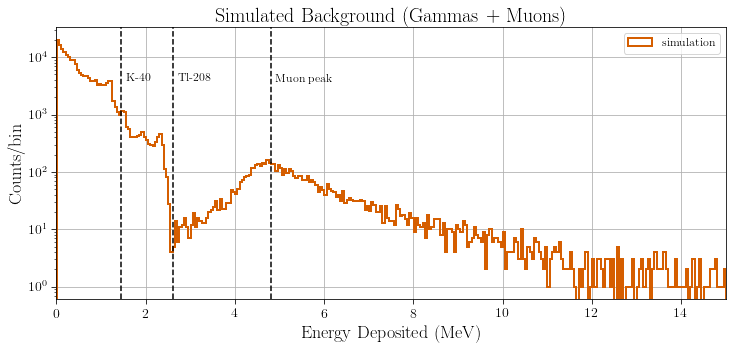

In [7]:
plt.figure(figsize=(12,5))

# Plot the gamma spectra
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(np.array(sim_mev), bins=300, range=(0.01, 15), histtype="step", lw=2, label = "simulation")

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.57,3.8 * 10**3,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.72,3.8 * 10**3,'Tl-208')
plt.axvline(4.8, color='k', linestyle='--')
plt.text(4.91,3.8 * 10**3,'Muon peak')

plt.grid()
plt.yscale("log")
plt.xlabel("Energy Deposited (MeV)")
plt.ylabel("Counts/bin")
plt.legend()
plt.xlim(0,15)
plt.title("Simulated Background (Gammas + Muons)")
# plt.savefig("NBv3-MuonsGammasFluxSimForCUORE_v3.jpg")
plt.show()

### Load and read lab data from directory

In [8]:
sourceFolder = "/home/dt592/data/board1771_01192023_retestingSwirlyPanel/"

onlyfiles = [f for f in os.listdir(sourceFolder) if '.dat' in f]

data_list = []
for file in onlyfiles:
    data_list.append(dt5202_crunch(str(sourceFolder)+str(file), num_ev=100000000, num_ch=1))

data = data_list[0]
for i in range(1, len(data_list)):
    data = np.append(data, data_list[i])

[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674156932637)]
((33, 0, 1.67415693e+09, 0, 1), (0, 3, 7938, 8051))
[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674157533007)]
((33, 0, 1.67415753e+09, 0, 1), (0, 3, 1110, 8051))


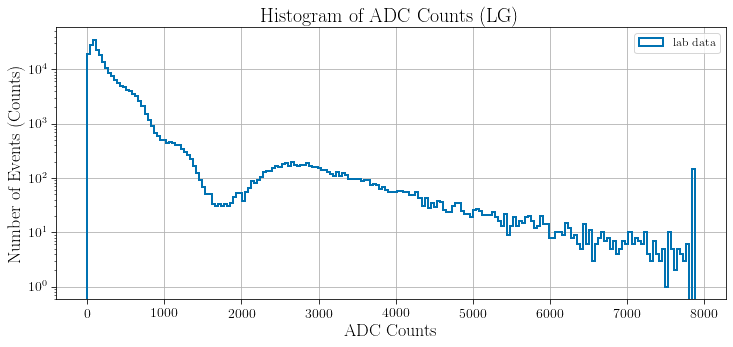

In [9]:
plt.figure(figsize=(12,5))

plt.hist(data['data']['low_gain']-ped, bins=200, lw = 2, label='lab data', histtype='step')

# plt.xlim(0,4000)
# plt.ylim(0,1000)
plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Histogram of ADC Counts (LG)')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

In [10]:
# Declare constants for conversion from ADC to PE/MeV

adc_mev = 538.3933387436877 # from "MuonPeakCalibration_Din_ThanksEmily_v1_cut.ipynb"
# adc_mev = 543.8338183067665
pe_mev = 53.95 # gotten from averaging two values from "OLD_MuonsAndGammas_SimulationFitting_Din_v2_w_Caesium.ipynb"

In [11]:
# Convert lab data to MeV

d = data['data']['low_gain']-ped
lab_mev = (d.astype('float64'))/adc_mev # lab data in MeV

<Figure size 864x360 with 0 Axes>

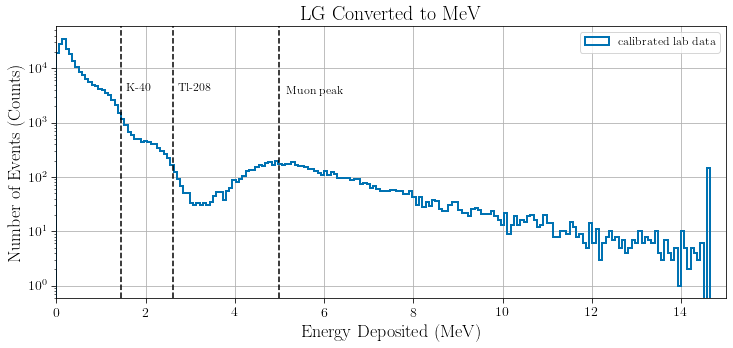

In [12]:
plt.figure(figsize=(12,5))
fig, ax = plt.subplots(figsize=(12,5))

plt.hist(lab_mev, bins=200, histtype='step', lw = 2, label='calibrated lab data')

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.57,3.8 * 10**3,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.72,3.8 * 10**3,'Tl-208')
trans = ax.get_xaxis_transform() # the x coords of this transformation are data, and the y coord are axes
plt.axvline(5, color='k', linestyle='--')
plt.text(5.15,0.75,'Muon peak',transform=trans)

plt.xlim(0,15)
# plt.ylim(0,1000)
plt.xlabel('Energy Deposited (MeV)')
plt.ylabel('Number of Events (Counts)')
plt.title('LG Converted to MeV')
plt.yscale('log')
plt.legend()
plt.grid()
# plt.savefig("NBv3-SwirlyData.jpg")
plt.show()

### Smearing first attempt (Constant sigma)

Using the sigma calculated from the gaussian Cs-137 fit, I applied smearing using the following function as a sort of “first pass.”

Because we are applying smearing in PE but the plot is in MeV, I am converting smearing to PE first when applying it, and then back to MeV for the plot, hence the *pe_mev multiplication.

Here is the first attempt with a “constant” smearing. Of course, smearing is not necessarily constant with energy, so for my second attempt I will try modeling it linearly and see what happens.

In [13]:
sim_pe = sim_mev * pe_mev
g_pe = g_mev * pe_mev
mu_pe = mu_mev * pe_mev

<Figure size 864x864 with 0 Axes>

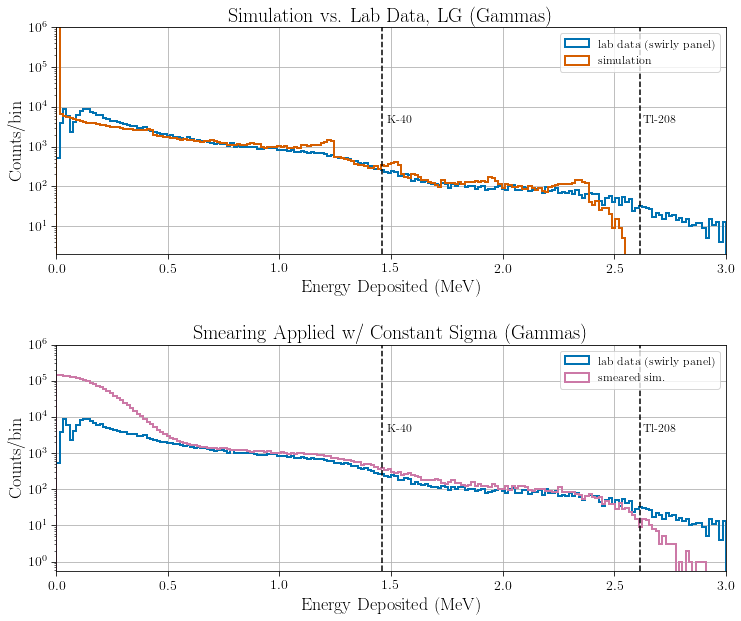

In [14]:
plt.figure(figsize=(12,12))
fig, axs = plt.subplots(1,1,figsize=(12,10))

sigma = 0.159223 # Get the sigma in MeV from "Cs137_GaussFitting_ForResolution_Din_vz1.ipynb"
sigma_pe = sigma * pe_mev # Convert to PE

mugam_cut = 3 # separation between muon peak and gamma bg
lv = 3.8 * 10**3

#apply smearing
bg_smeared = np.random.normal(loc=g_pe, scale = sigma_pe)

# Plot 1: Gamma simulation + lab data, gamma smearing + lab data
# plt.figure(1)

plt.subplot(211)

plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(g_mev, bins=200, range=(0, mugam_cut), histtype='step', label='simulation', lw=2) #simulation

#label isotope peaks
plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,lv,'Tl-208')

plt.legend(loc=1)
plt.grid()
plt.xlabel('Energy Deposited (MeV)');
plt.xlim(0, mugam_cut)
# plt.ylim(0, 10**6)
plt.ylabel('Counts/bin');
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Simulation vs. Lab Data, LG (Gammas)')

# plt.savefig("LabDataVsActualMuons.jpg")

plt.subplot(212)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(bg_smeared/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared sim.', lw=2) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,lv,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Smearing Applied w/ Constant Sigma (Gammas)')

plt.subplots_adjust(hspace=0.4)

# plt.savefig("NBv3-ConstSmearing-Gammas.jpg")

plt.show()

<Figure size 864x864 with 0 Axes>

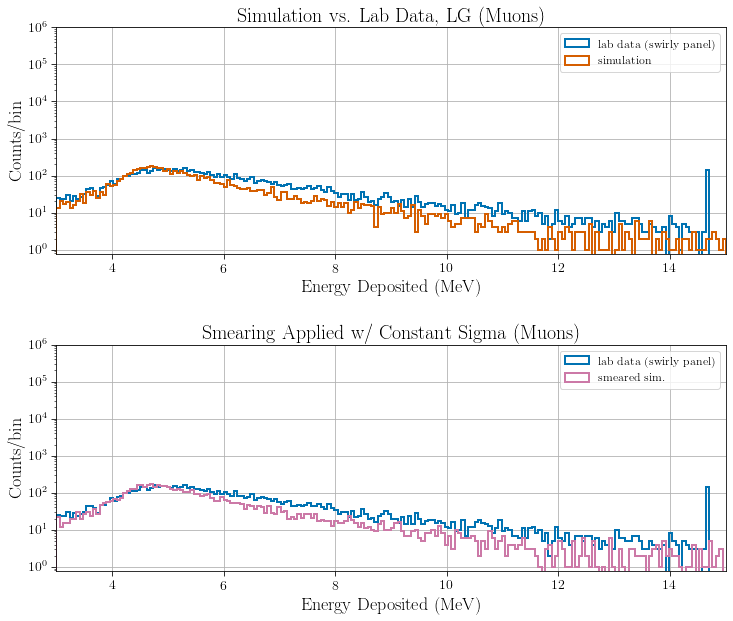

In [15]:
plt.figure(figsize=(12,12))
fig, axs = plt.subplots(1,1,figsize=(12,10))

# mugam_cut = 2.5 # separation between muon peak and gamma bg
lv = 3.8 * 10**3

#apply smearing
bg_smeared = np.random.normal(loc=mu_pe, scale = sigma_pe)

# Plot 1: Gamma simulation + lab data, gamma smearing + lab data
# plt.figure(1)

plt.subplot(211)

plt.hist(lab_mev, bins=200, range=(mugam_cut, 15), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(mu_mev, bins=200, range=(mugam_cut, 15), histtype='step', label='simulation', lw=2) #simulation

#label isotope peaks
# plt.axvline(1.460, color='k', linestyle='--')
# plt.text(1.48,lv,'K-40')
# plt.axvline(2.614, color='k', linestyle='--')
# plt.text(2.63,lv,'Tl-208')

plt.legend(loc=1)
plt.grid()
plt.xlabel('Energy Deposited (MeV)');
plt.xlim(mugam_cut, 15)
# plt.ylim(0, 10**6)
plt.ylabel('Counts/bin');
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Simulation vs. Lab Data, LG (Muons)')

# plt.savefig("LabDataVsActualMuons.jpg")

plt.subplot(212)
plt.hist(lab_mev, bins=200, range=(mugam_cut, 15), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(bg_smeared/pe_mev, bins=200, range=(mugam_cut, 15), histtype='step', label='smeared sim.', lw=2) #smeared

plt.legend(loc=1)

# plt.axvline(1.460, color='k', linestyle='--')
# plt.text(1.48,lv,'K-40')
# plt.axvline(2.614, color='k', linestyle='--')
# plt.text(2.63,lv,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(mugam_cut, 15)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Smearing Applied w/ Constant Sigma (Muons)')

plt.subplots_adjust(hspace=0.4)

# plt.savefig("NBv3-ConstSmearing-Muons.jpg")

plt.show()

<Figure size 864x864 with 0 Axes>

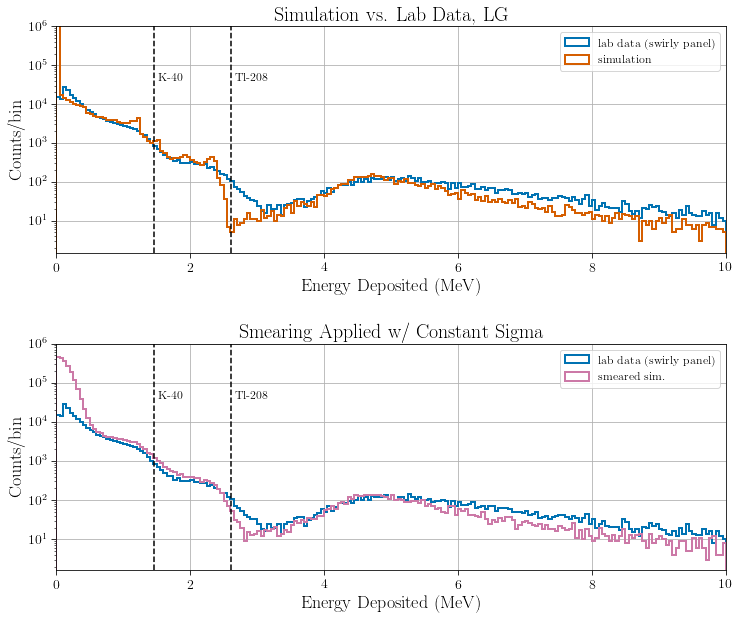

In [16]:
plt.figure(figsize=(12,12))
fig, axs = plt.subplots(1,1,figsize=(12,10))

sigma = 0.159223 # Get the sigma in MeV from "Cs137_GaussFitting_ForResolution_Din_vz1.ipynb"
sigma_pe = sigma * pe_mev # Convert to PE

mugam_cut = 10 # separation between muon peak and gamma bg
lv = 3.8 * 10**4

#apply smearing
bg_smeared = np.random.normal(loc=sim_mev * pe_mev, scale = sigma_pe)

# Plot 1: Gamma simulation + lab data, gamma smearing + lab data
# plt.figure(1)

plt.subplot(211)

plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(sim_mev, bins=200, range=(0, mugam_cut), histtype='step', label='simulation', lw=2) #simulation

#label isotope peaks
plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.52,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.67,lv,'Tl-208')

plt.legend(loc=1)
plt.grid()
plt.xlabel('Energy Deposited (MeV)');
plt.xlim(0, mugam_cut)
# plt.ylim(0, 10**6)
plt.ylabel('Counts/bin');
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Simulation vs. Lab Data, LG')

# plt.savefig("LabDataVsActualMuons.jpg")

plt.subplot(212)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(bg_smeared/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared sim.', lw=2) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.52,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.67,lv,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Smearing Applied w/ Constant Sigma')

plt.subplots_adjust(hspace=0.4)

# plt.savefig("NBv3-ConstSmearing-FullSpectrum.jpg")

plt.show()

### Smearing second attempt (linear sigma)

<Figure size 864x864 with 0 Axes>

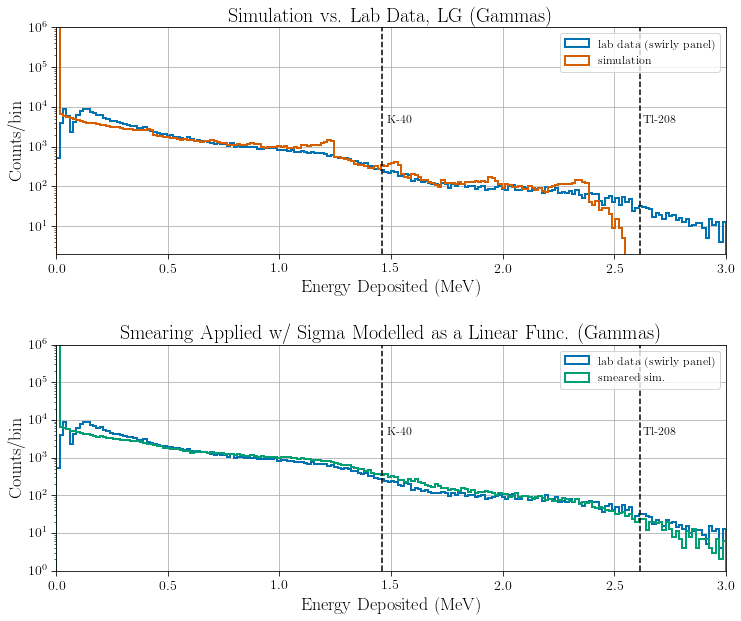

In [17]:
plt.figure(figsize=(12,12))
fig, axs = plt.subplots(1,1,figsize=(12,10))

lin_sigma = sigma / 0.662 
lin_sigma_pe = lin_sigma * pe_mev # Convert to PE

mugam_cut = 3 # separation between muon peak and gamma bg
lv = 3.8 * 10**3

#apply smearing
bg_smeared_lin_g_pe = np.random.normal(loc=g_pe, scale = 0.01 * lin_sigma_pe * g_pe)

# Plot 1: Gamma simulation + lab data, gamma smearing + lab data
# plt.figure(1)

plt.subplot(211)

plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(g_mev, bins=200, range=(0, mugam_cut), histtype='step', label='simulation', lw=2) #simulation

#label isotope peaks
plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,lv,'Tl-208')

plt.legend(loc=1)
plt.grid()
plt.xlabel('Energy Deposited (MeV)');
plt.xlim(0, mugam_cut)
# plt.ylim(0, 10**6)
plt.ylabel('Counts/bin');
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Simulation vs. Lab Data, LG (Gammas)')

# plt.savefig("LabDataVsActualMuons.jpg")

plt.subplot(212)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist(bg_smeared_lin_g_pe/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared sim.', lw=2) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,lv,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Smearing Applied w/ Sigma Modelled as a Linear Func. (Gammas)')

plt.subplots_adjust(hspace=0.4)

# plt.savefig("NBv3-LinSmearing-Gammas.jpg")

plt.show()

<Figure size 864x864 with 0 Axes>

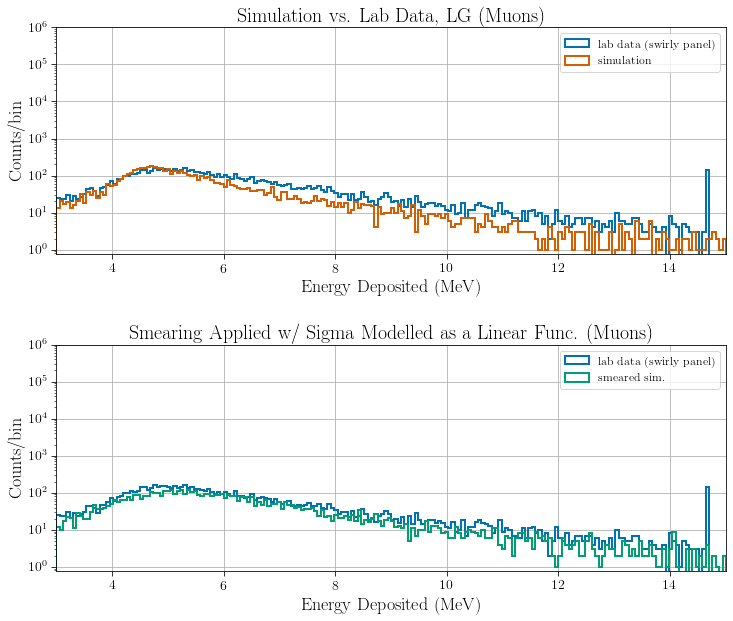

In [18]:
plt.figure(figsize=(12,12))
fig, axs = plt.subplots(1,1,figsize=(12,10))

# mugam_cut = 2.5 # separation between muon peak and gamma bg
# lv = 3.8 * 10**3

#apply smearing
bg_smeared_lin_mu_pe = 1.095 * np.random.normal(loc=mu_pe, scale = 0.01 * lin_sigma_pe * mu_pe)

plt.subplot(211)

plt.hist(lab_mev, bins=200, range=(mugam_cut, 15), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(mu_mev, bins=200, range=(mugam_cut, 15), histtype='step', label='simulation', lw=2) #simulation

plt.legend(loc=1)
plt.grid()
plt.xlabel('Energy Deposited (MeV)');
plt.xlim(mugam_cut, 15)
# plt.ylim(0, 10**6)
plt.ylabel('Counts/bin');
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Simulation vs. Lab Data, LG (Muons)')

# plt.savefig("LabDataVsActualMuons.jpg")

plt.subplot(212)
plt.hist(lab_mev, bins=200, range=(mugam_cut, 15), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist(bg_smeared_lin_mu_pe/pe_mev, bins=200, range=(mugam_cut, 15), histtype='step', label='smeared sim.', lw=2) #smeared

plt.legend(loc=1)

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(mugam_cut, 15)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Smearing Applied w/ Sigma Modelled as a Linear Func. (Muons)')

plt.subplots_adjust(hspace=0.4)

# plt.savefig("NBv3-LinSmearing-Muons.jpg")

plt.show()

<Figure size 864x864 with 0 Axes>

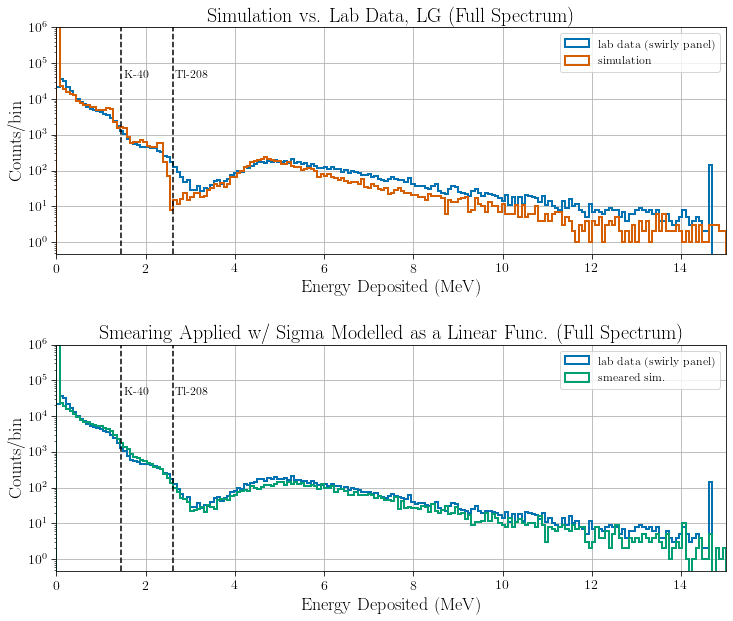

In [19]:
plt.figure(figsize=(12,12))
fig, axs = plt.subplots(1,1,figsize=(12,10))

lv = 3.8 * 10**4

#apply smearing
bg_smeared_lin_sim_pe = np.concatenate((bg_smeared_lin_g_pe, bg_smeared_lin_mu_pe))

# Plot 1: Gamma simulation + lab data, gamma smearing + lab data
# plt.figure(1)

plt.subplot(211)

plt.hist(lab_mev, bins=200, range=(0, 15), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(sim_mev, bins=200, range=(0, 15), histtype='step', label='simulation', lw=2) #simulation

#label isotope peaks
plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.52,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.67,lv,'Tl-208')

plt.legend(loc=1)
plt.grid()
plt.xlabel('Energy Deposited (MeV)');
plt.xlim(0, 15)
# plt.ylim(0, 10**6)
plt.ylabel('Counts/bin');
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Simulation vs. Lab Data, LG (Full Spectrum)')

# plt.savefig("LabDataVsActualMuons.jpg")

plt.subplot(212)
plt.hist(lab_mev, bins=200, range=(0, 15), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist(bg_smeared_lin_sim_pe/pe_mev, bins=200, range=(0, 15), histtype='step', label='smeared sim.', lw=2) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.52,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.67,lv,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, 15)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Smearing Applied w/ Sigma Modelled as a Linear Func. (Full Spectrum)')

plt.subplots_adjust(hspace=0.4)

# plt.savefig("NBv3-LinSmearing-FullSpectrum.jpg")

plt.show()

### Use PyROOT to get Chi2 value for the smearing

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 1 event.



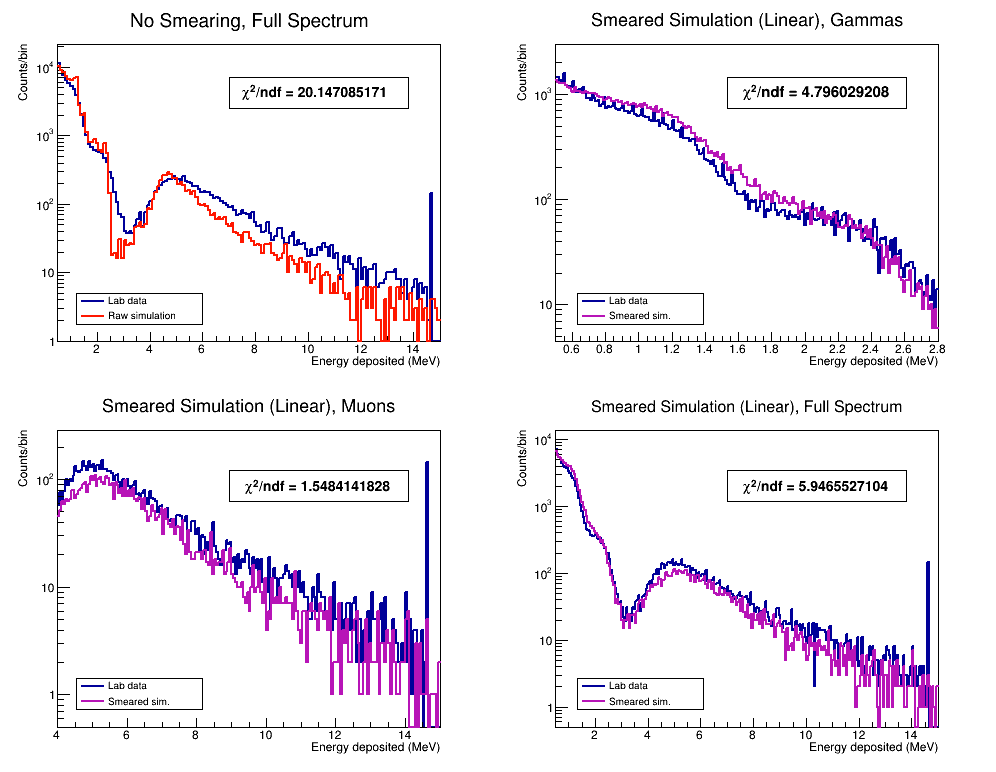

In [20]:
# Try this
# leg = ROOT.TLegend()
c1 = ROOT.TCanvas('c1',"",1000,800)
# title = ROOT.TPaveText(.4,0.5,.6,0.52)
ROOT.gStyle.SetStatFontSize(.08)
ROOT.gStyle.SetStatW(0.4)
c1.Divide(2,2)

#

c1.cd(1)
lab_th = ROOT.TH1D('No Smearing, Full Spectrum','No Smearing, Full Spectrum',150,0.5,15)
fill_hist(lab_th,lab_mev)
lab_th.Draw()
lab_th.GetXaxis().SetTitle("Energy deposited (MeV)")
lab_th.GetYaxis().SetTitle("Counts/bin")
lab_th.SetLineWidth(2)

lab_sim_th = ROOT.TH1D('Simulation (No Smearing)','',150,0.5,15)
fill_hist(lab_sim_th,sim_mev)
lab_sim_th.Draw("same")
lab_sim_th.SetLineColor(99)
lab_sim_th.SetLineWidth(2)

# rp1 = ROOT.TRatioPlot(lab_th, lab_sim_th)
# rp1.GetUpperPad.SetLogy()

ROOT.gPad.SetLogy()
ROOT.gStyle.SetOptStat(2)
# rp1.Draw()



chi2_1 = " #chi^{2}/ndf = " + str(round(lab_sim_th.Chi2Test(lab_th, "CHI2/NDF"), 9)) + " "

#

c1.cd(2)
lab_g_th = ROOT.TH1D('lab_g', 'Smeared Simulation (Linear), Gammas', 200, 0.5, 2.8)
smeared_lin_g_th = ROOT.TH1D('smeared1', 'Smeared Simulation (Linear), Gammas', 200, 0.5, 2.8)
fill_hist(lab_g_th, lab_mev)
fill_hist(smeared_lin_g_th, bg_smeared_lin_g_pe/pe_mev)

lab_g_th.Draw()
lab_g_th.GetXaxis().SetTitle("Energy deposited (MeV)")
lab_g_th.GetYaxis().SetTitle("Counts/bin")
lab_g_th.SetLineWidth(2)

smeared_lin_g_th.Draw("same")
smeared_lin_g_th.GetXaxis().SetTitle("Energy deposited (MeV)")
smeared_lin_g_th.GetYaxis().SetTitle("Counts/bin")
smeared_lin_g_th.SetLineColor(222)
smeared_lin_g_th.SetLineWidth(2)

# ROOT.gPad.SetGrid()
ROOT.gPad.SetLogy()
ROOT.gStyle.SetOptStat(0)

chi2_2 = " #chi^{2}/ndf = " + str(round(smeared_lin_g_th.Chi2Test(lab_g_th, "CHI2/NDF"), 9)) + " "

#

c1.cd(3)
lab_mu_th = ROOT.TH1D('lab_mu', 'Smeared Simulation (Linear), Muons', 200, 4, 15)
fill_hist(lab_mu_th, lab_mev)
smeared_lin_mu_th = ROOT.TH1D('smeared2', 'Smeared Simulation (Linear), Muons', 200, 4, 15)
fill_hist(smeared_lin_mu_th, bg_smeared_lin_mu_pe/pe_mev)

lab_mu_th.Draw()
lab_mu_th.GetXaxis().SetTitle("Energy deposited (MeV)")
lab_mu_th.GetYaxis().SetTitle("Counts/bin")
lab_mu_th.SetLineWidth(2)

smeared_lin_mu_th.Draw("same")
smeared_lin_mu_th.GetXaxis().SetTitle("Energy deposited (MeV)")
smeared_lin_mu_th.GetYaxis().SetTitle("Counts/bin")
smeared_lin_mu_th.SetLineColor(222)
smeared_lin_mu_th.SetLineWidth(2)

ROOT.gPad.SetLogy()
ROOT.gStyle.SetOptStat(0)

chi2_3 = " #chi^{2}/ndf = " + str(round(smeared_lin_mu_th.Chi2Test(lab_mu_th, "CHI2/NDF"), 10)) + " "

#

c1.cd(4)
lab_2_th = ROOT.TH1D('lab_2', 'Smeared Simulation (Linear), Full Spectrum', 250, 0.5, 15)
fill_hist(lab_2_th, lab_mev)
smeared_lin_full_th = ROOT.TH1D('smeared3', 'Smeared Simulation (Linear), Full Spectrum', 250, 0.5, 15)
fill_hist(smeared_lin_full_th, bg_smeared_lin_sim_pe/pe_mev)

lab_2_th.Draw()
lab_2_th.GetXaxis().SetTitle("Energy deposited (MeV)")
lab_2_th.GetYaxis().SetTitle("Counts/bin")
lab_2_th.SetLineWidth(2)

smeared_lin_full_th.Draw("same")
smeared_lin_full_th.GetXaxis().SetTitle("Energy deposited (MeV)")
smeared_lin_full_th.GetYaxis().SetTitle("Counts/bin")
smeared_lin_full_th.SetLineWidth(2)

smeared_lin_full_th.SetLineColor(222)

ROOT.gPad.SetLogy()
ROOT.gStyle.SetOptStat(0)

chi2_4 = " #chi^{2}/ndf = " + str(round(smeared_lin_full_th.Chi2Test(lab_2_th, "CHI2/NDF"), 10)) + " "

c1.cd()

title1 = ROOT.TPaveText(.23,.9,.41,.86)
title1.AddText(chi2_1)
title1.SetMargin(0.05)
title1.SetBorderSize(1)
title1.SetFillColor(0)
title1.Draw()

title2 = ROOT.TPaveText(.73,.9,.91,.86)
title2.AddText(chi2_2)
title2.SetMargin(0.05)
title2.SetBorderSize(1)
title2.SetFillColor(0)
title2.Draw()

title3 = ROOT.TPaveText(.23,.39,.41,.35)
title3.AddText(chi2_3)
title3.SetMargin(0.05)
title3.SetBorderSize(1)
title3.SetFillColor(0)
title3.Draw()

title4 = ROOT.TPaveText(.73,.39,.91,.35)
title4.AddText(chi2_4)
title4.SetMargin(0.05)
title4.SetBorderSize(1)
title4.SetFillColor(0)
title4.Draw()

legend1 = ROOT.TLegend(0.077,0.58,0.203,0.62)
legend1.AddEntry(lab_th,"Lab data","l")
legend1.AddEntry(lab_sim_th,"Raw simulation","l")
legend1.Draw()

legend2 = ROOT.TLegend(0.58,0.58,0.706,0.62)
legend2.AddEntry(lab_g_th,"Lab data","l")
legend2.AddEntry(smeared_lin_g_th,"Smeared sim.","l")
legend2.Draw()

legend3 = ROOT.TLegend(0.077,0.081,0.203,0.121)
legend3.AddEntry(lab_mu_th,"Lab data","l")
legend3.AddEntry(smeared_lin_mu_th,"Smeared sim.","l")
legend3.Draw()

legend4 = ROOT.TLegend(0.58,0.081,0.706,0.121)
legend4.AddEntry(lab_2_th,"Lab data","l")
legend4.AddEntry(smeared_lin_full_th,"Smeared sim.","l")
legend4.Draw()

c1.Draw()
# c1.SaveAs("NBv3_LinSmearing_CHI2NDF_better.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TFile::Append>: Replacing existing TH1: No Smearing, Full Spectrum (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Simulation (No Smearing) (Potential memory leak).
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 9 points have been skipped
Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 1 event.

Warning in <TFile::Append>: Replacing existing TH1: lab_g (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: smeared1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: lab_mu (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: smeared2 (Potential memory leak).
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 5 points have be

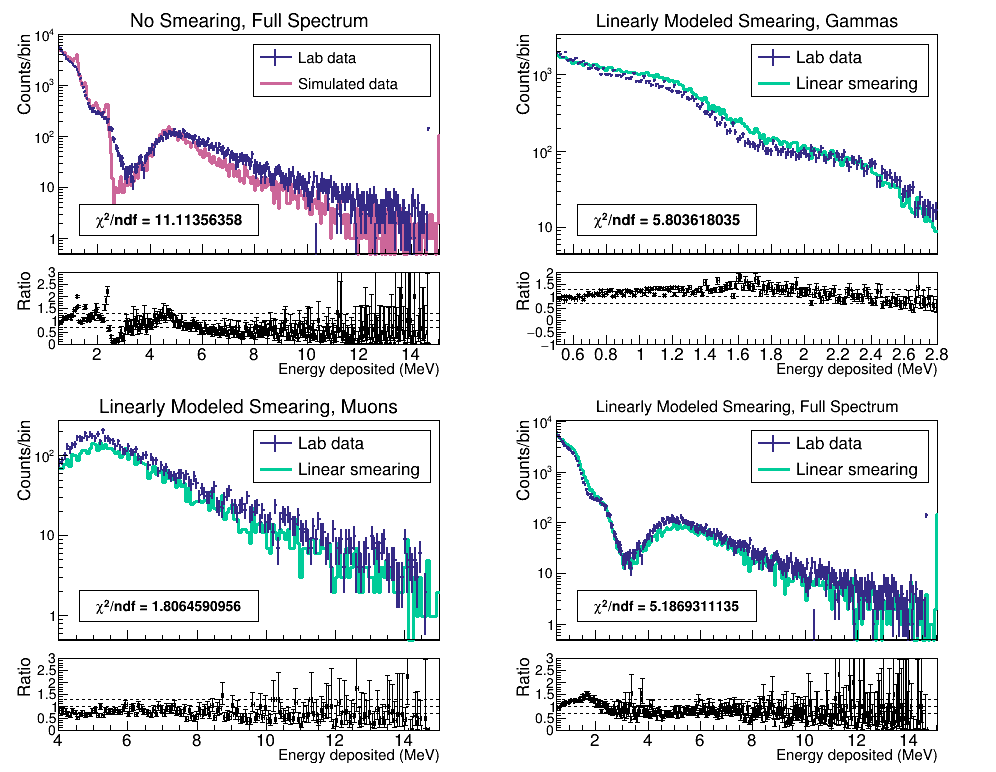

In [80]:
# Try this
c1 = ROOT.TCanvas('c1',"",1000,800)
ROOT.gStyle.SetStatFontSize(.08)
ROOT.gStyle.SetStatW(0.4)
c1.Divide(2,2)

#

c1.cd(1)
ROOT.gStyle.SetTitleFontSize(0.075)
ROOT.gStyle.SetPalette(ROOT.kBird)

lab_th = ROOT.TH1D('No Smearing, Full Spectrum','No Smearing, Full Spectrum',300,0.5,15)
fill_hist(lab_th,lab_mev)
lab_th.Draw("plc pmc")
lab_th.GetXaxis().SetTitle("Energy deposited (MeV)")
# lab_th.GetYaxis().SetTitle("Counts/bin")
lab_th.SetLineWidth(2)

lab_sim_th = ROOT.TH1D('Simulation (No Smearing)','No Smearing, Full Spectrum',300,0.5,15)
fill_hist(lab_sim_th,sim_mev)
# lab_sim_th.Draw("plc pmc same")
lab_sim_th.GetXaxis().SetTitle("Energy deposited (MeV)")
lab_sim_th.SetLineColor(ROOT.kPink+2)
lab_sim_th.SetLineWidth(3)

rp1 = ROOT.TRatioPlot(lab_sim_th,lab_th)

ROOT.gPad.SetLogy()
ROOT.gStyle.SetOptStat(2)
rp1.Draw()

rp1.GetLowerRefYaxis().SetTitle("Ratio")
rp1.GetLowerRefYaxis().SetTitleOffset(0.9)
rp1.GetUpperRefYaxis().SetTitle("Counts/bin")
rp1.GetUpperRefYaxis().SetTitleOffset(0.9)
rp1.GetLowerRefYaxis().SetRangeUser(0,3)

rp1.GetLowerRefYaxis().SetLabelSize(.04)
rp1.GetLowerRefYaxis().SetTitleSize(.05)
rp1.GetUpperRefYaxis().SetLabelSize(.04)
rp1.GetUpperRefYaxis().SetTitleSize(.05)
rp1.GetLowerRefXaxis().SetLabelSize(.05)
rp1.GetLowerRefXaxis().SetTitleSize(.045)


chi2_1 = " #chi^{2}/ndf = " + str(round(lab_sim_th.Chi2Test(lab_th, "CHI2/NDF"), 8)) + " "

legend1 = ROOT.TLegend(0.51,0.76,0.88,0.90)
legend1.AddEntry(lab_th,"Lab data","le")
legend1.AddEntry(lab_sim_th,"Simulated data","l")
legend1.Draw()

#

c1.cd(2)
ROOT.gStyle.SetTitleFontSize(0.075)
ROOT.gStyle.SetPalette(ROOT.kBird)

lab_g_th = ROOT.TH1D('lab_g', 'Smeared Simulation (Linear), Gammas', 150, 0.5, 2.8)
smeared_lin_g_th = ROOT.TH1D('smeared1', 'Linearly Modeled Smearing, Gammas', 150, 0.5, 2.8)
fill_hist(lab_g_th, lab_mev)
fill_hist(smeared_lin_g_th, bg_smeared_lin_g_pe/pe_mev)

lab_g_th.Draw("plc pmc")
lab_g_th.GetXaxis().SetTitle("Energy deposited (MeV)")
# lab_g_th.GetYaxis().SetTitle("Counts/bin")
lab_g_th.SetLineWidth(2)

# smeared_lin_g_th.Draw("plc pmc same")
smeared_lin_g_th.GetXaxis().SetTitle("Energy deposited (MeV)")
# smeared_lin_g_th.GetYaxis().SetTitle("Counts/bin")
smeared_lin_g_th.SetLineColor(ROOT.kTeal - 1)
smeared_lin_g_th.SetLineWidth(3)

rp2 = ROOT.TRatioPlot(smeared_lin_g_th,lab_g_th)
# rp2.GetUpperRefYaxis().SetTitle("Counts/bin")
# rp2.GetLowerRefYaxis().SetTitle("Ratio")

# ROOT.gPad.SetGrid()
# ROOT.gPad.SetLogy()
ROOT.gStyle.SetOptStat(0)
ROOT.gPad.SetLogy()

rp2.Draw()

rp2.GetLowerRefYaxis().SetTitle("Ratio")
rp2.GetLowerRefYaxis().SetTitleOffset(.9)
rp2.GetUpperRefYaxis().SetTitle("Counts/bin")
rp2.GetUpperRefYaxis().SetTitleOffset(.9)
# rp2.GetLowerRefYaxis().SetNdivisions(21)
# rp2.GetUpperRefYaxis().SetRange(0,10**4)
rp2.GetLowerRefYaxis().SetRangeUser(-1,2)

rp2.GetLowerRefYaxis().SetLabelSize(.04)
rp2.GetLowerRefYaxis().SetTitleSize(.05)
rp2.GetUpperRefYaxis().SetLabelSize(.04)
rp2.GetUpperRefYaxis().SetTitleSize(.05)
rp2.GetLowerRefXaxis().SetLabelSize(.05)
rp2.GetLowerRefXaxis().SetTitleSize(.045)

chi2_2 = " #chi^{2}/ndf = " + str(round(smeared_lin_g_th.Chi2Test(lab_g_th, "CHI2/NDF"), 9)) + " "

legend2 = ROOT.TLegend(0.51,0.76,0.88,0.90)
legend2.AddEntry(lab_th,"Lab data","le")
legend2.AddEntry(smeared_lin_g_th,"Linear smearing","l")
legend2.Draw()

#

c1.cd(3)
ROOT.gStyle.SetTitleFontSize(0.075)
ROOT.gStyle.SetPalette(ROOT.kBird)

lab_mu_th = ROOT.TH1D('lab_mu', 'Smeared Simulation (Linear), Muons', 150, 4, 15)
fill_hist(lab_mu_th, lab_mev)
smeared_lin_mu_th = ROOT.TH1D('smeared2', 'Linearly Modeled Smearing, Muons', 150, 4, 15)
fill_hist(smeared_lin_mu_th, bg_smeared_lin_mu_pe/pe_mev)

lab_mu_th.Draw("plc pmc")
lab_mu_th.GetXaxis().SetTitle("Energy deposited (MeV)")
# lab_mu_th.GetYaxis().SetTitle("Counts/bin")
lab_mu_th.SetLineWidth(2)

# smeared_lin_mu_th.Draw("same")
smeared_lin_mu_th.GetXaxis().SetTitle("Energy deposited (MeV)")
smeared_lin_mu_th.GetYaxis().SetTitle("Counts/bin")
smeared_lin_mu_th.SetLineColor(ROOT.kTeal - 1)
smeared_lin_mu_th.SetLineWidth(3)

rp3 = ROOT.TRatioPlot(smeared_lin_mu_th,lab_mu_th)
# rp3.GetLowerRefYaxis().SetTitle("Ratio")
# rp3.GetUpperRefYaxis().SetTitle("Counts/bin")

ROOT.gPad.SetLogy()
ROOT.gStyle.SetOptStat(0)

rp3.Draw()
rp3.GetLowerRefYaxis().SetTitle("Ratio")
rp3.GetLowerRefYaxis().SetTitleOffset(.9)
rp3.GetUpperRefYaxis().SetTitle("Counts/bin")
rp3.GetUpperRefYaxis().SetTitleOffset(.9)
rp3.GetLowerRefYaxis().SetRangeUser(0,3)

rp3.GetLowerRefYaxis().SetLabelSize(.04)
rp3.GetLowerRefYaxis().SetTitleSize(.05)
rp3.GetUpperRefYaxis().SetLabelSize(.04)
rp3.GetUpperRefYaxis().SetTitleSize(.05)
rp3.GetLowerRefXaxis().SetLabelSize(.05)
rp3.GetLowerRefXaxis().SetTitleSize(.045)

chi2_3 = " #chi^{2}/ndf = " + str(round(smeared_lin_mu_th.Chi2Test(lab_mu_th, "CHI2/NDF"), 10)) + " "

legend3 = ROOT.TLegend(0.51,0.76,0.88,0.90)
legend3.AddEntry(lab_th,"Lab data","le")
legend3.AddEntry(smeared_lin_mu_th,"Linear smearing","l")
legend3.Draw()

#

c1.cd(4)
ROOT.gStyle.SetPalette(ROOT.kBird)
ROOT.gStyle.SetTitleFontSize(0.075)
lab_2_th = ROOT.TH1D('lab_2', 'Smeared Simulation (Linear), Full Spectrum', 300, 0.5, 15)
fill_hist(lab_2_th, lab_mev)
smeared_lin_full_th = ROOT.TH1D('smeared3', 'Linearly Modeled Smearing, Full Spectrum', 300, 0.5, 15)
fill_hist(smeared_lin_full_th, bg_smeared_lin_sim_pe/pe_mev)

lab_2_th.Draw("plc pmc")
lab_2_th.GetXaxis().SetTitle("Energy deposited (MeV)")
lab_2_th.GetYaxis().SetTitle("Counts/bin")
lab_2_th.SetLineWidth(2)

# smeared_lin_full_th.Draw("same")
smeared_lin_full_th.GetXaxis().SetTitle("Energy deposited (MeV)")
smeared_lin_full_th.GetYaxis().SetTitle("Counts/bin")
smeared_lin_full_th.SetLineWidth(3)

smeared_lin_full_th.SetLineColor(ROOT.kTeal-1)

rp4 = ROOT.TRatioPlot(smeared_lin_full_th,lab_2_th)
# rp4.GetLowerRefYaxis().SetTitle("Ratio")
# rp4.GetUpperRefYaxis().SetTitle("Counts/bin")

ROOT.gPad.SetLogy()
ROOT.gStyle.SetOptStat(0)

rp4.Draw()

rp4.GetLowerRefYaxis().SetTitle("Ratio")
rp4.GetLowerRefYaxis().SetTitleOffset(.9)
rp4.GetUpperRefYaxis().SetTitle("Counts/bin")
rp4.GetUpperRefYaxis().SetTitleOffset(.9)
rp4.GetLowerRefYaxis().SetRangeUser(0,3)

rp4.GetLowerRefYaxis().SetLabelSize(.04)
rp4.GetLowerRefYaxis().SetTitleSize(.05)
rp4.GetUpperRefYaxis().SetLabelSize(.04)
rp4.GetUpperRefYaxis().SetTitleSize(.05)
rp4.GetLowerRefXaxis().SetLabelSize(.05)
rp4.GetLowerRefXaxis().SetTitleSize(.045)

chi2_4 = " #chi^{2}/ndf = " + str(round(smeared_lin_full_th.Chi2Test(lab_2_th, "CHI2/NDF"), 10)) + " "

legend4 = ROOT.TLegend(0.51,0.76,0.88,0.90)
legend4.AddEntry(lab_th,"Lab data","le")
legend4.AddEntry(smeared_lin_full_th,"Linear smearing","l")
legend4.Draw()

c1.cd()

title1 = ROOT.TPaveText(.08,.695,.26,.735)
title1.AddText(chi2_1)
title1.SetMargin(0.05)
title1.SetBorderSize(1)
title1.SetFillColor(0)
title1.Draw()

title2 = ROOT.TPaveText(.58,.695,.76,.735)
title2.AddText(chi2_2)
title2.SetMargin(0.05)
title2.SetBorderSize(1)
title2.SetFillColor(0)
title2.Draw()

title3 = ROOT.TPaveText(.08,.195,.26,.235)
title3.AddText(chi2_3)
title3.SetMargin(0.05)
title3.SetBorderSize(1)
title3.SetFillColor(0)
title3.Draw()

title4 = ROOT.TPaveText(.58,.195,.76,.235)
title4.AddText(chi2_4)
title4.SetMargin(0.05)
title4.SetBorderSize(1)
title4.SetFillColor(0)
title4.Draw()

# legend1 = ROOT.TLegend(0.077,0.69,0.203,0.73)
# legend1.AddEntry(lab_th,"Lab data","le")
# legend1.AddEntry(lab_sim_th,"Raw simulation","l")
# legend1.Draw()

# legend2 = ROOT.TLegend(0.58,0.69,0.706,0.73)
# legend2.AddEntry(lab_g_th,"Lab data","le")
# legend2.AddEntry(smeared_lin_g_th,"Smeared sim.","l")
# legend2.Draw()

# legend3 = ROOT.TLegend(0.077,0.19,0.203,0.23)
# legend3.AddEntry(lab_mu_th,"Lab data","le")
# legend3.AddEntry(smeared_lin_mu_th,"Smeared sim.","l")
# legend3.Draw()

# legend4 = ROOT.TLegend(0.58,0.19,0.706,0.23)
# legend4.AddEntry(lab_2_th,"Lab data","le")
# legend4.AddEntry(smeared_lin_full_th,"Smeared sim.","l")
# legend4.Draw()

c1.Draw()
c1.SaveAs("NBv3_LinSmearing_CHI2NDF_betterer_v6.png")